In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

def show_data(data,fit_info = (False,None,False,None),filename='',show = False,mag_only = True):
    if show:
        if mag_only:
            fig1 = plt.figure(constrained_layout = True)
            ax = fig1.add_subplot(1, 1, 1)
            ax.scatter(data['freq'],data['vmag']*data['vamp'],color='green',label=filename)
            if fit_info[0]:
                bestpars1 = fit_info[1]
                ax.plot(data['freq'],data['vamp']*full_lorenzian_fit_with_skew(data['freq'],*bestpars1),label='Full Lorenzian Fit')
                
            if fit_info[2]:
                bestpars2 = fit_info[3]
                ax.plot(data['freq'],data['vamp']*simple_lorenzian_fit(data['freq'],*bestpars2),label = 'Refined Fit')
            ax.legend()  
            ax.set_xlabel('Frequency (kHz)')
            ax.set_ylabel('Voltage Magnitude (mV)')
            ax.set_title('Lorenzian Fit for '+filename)
        else:
            fig0 = plt.figure(constrained_layout = True)
            ax1 = fig0.add_subplot(3, 1, 1)
            ax2 = fig0.add_subplot(3, 1, 2)
            ax3 = fig0.add_subplot(3, 1, 3)
            ax1.set_xlabel('Frequency (kHz)')
            ax2.set_xlabel('Frequency (kHz)')
            ax3.set_xlabel('Frequency (kHz)')
            ax1.set_ylabel('Vx (mV)')
            ax2.set_ylabel('Vx (mV)')
            ax3.set_ylabel('Voltage Magnitude (mV)')
            ax1.plot(data['freq'],data['vx'])
            ax2.plot(data['freq'],data['vy'])
            ax3.plot(data['freq'],data['vmag']*data['vamp'])

def cosort_lists(list_to_sort,list_to_cosort):
    out1 = np.zeros(l1 := len(list_to_sort))
    out2 = np.zeros(len(list_to_cosort))
    sorted_inds = np.argsort(np.argsort(list_to_sort))
    for i in range(l1):
        for j, ind in enumerate(sorted_inds):
            if i == ind:
                out1[i] = list_to_sort[j]
                out2[i] = list_to_cosort[j]
                break
    return out1, out2

def calc_mu(omega,sigma_x,sigma_y,length=2e-3,width=1e-3,tolerance = 1e-4):
    mu_0 = 4*np.pi*1e-7
    if width>length:
        b = length/2
        a = width/2
    else:
        a = length/2
        b = width/2
    total_sum = 0
    m = 1
    change = np.inf
    alpha_m_coef = np.pi/2/a
    gamma_m_coef = np.pi/2/b
    while np.abs(change)>tolerance:
        alpha_m = m * alpha_m_coef
        gamma_m = m * gamma_m_coef
        beta_m = np.sqrt(1j*omega*mu_0*sigma_x+alpha_m**2*sigma_x/sigma_y)
        delta_m = np.sqrt(1j*omega*mu_0*sigma_y+gamma_m**2*sigma_y/sigma_x)
        change = (np.tanh(beta_m*b)/(alpha_m*beta_m)+np.tanh(delta_m*a)/(gamma_m*delta_m))/m
        total_sum += change
        m+=2
    return total_sum*4/np.pi

def calc_power(omega,sigma_x,sigma_y,H_0,length=2e-3,width=1e-3,N_m=1,tolerance = 1e-4):
    mu = calc_mu(omega,sigma_x,sigma_y,length=length,width=width,tolerance = tolerance)
    return 1j*.5*omega*4*np.pi*1e-7*H_0*mu/(1+N_m*(mu-1))

def full_Z(omega, C1, C2, L, R):
    A = (1-L*C2*omega**2)**2 + (R*C2*omega)**2
    B = L-(R**2*C2)-(C2*(L*omega)**2)
    return R/A +1j*(omega*B/A-1/(omega*C1))

def reflection_coeff(omega, C1, C2, L, R, Z0=50):
    ZL = full_Z(omega, C1, C2,L,R)
    return (ZL/Z0-1)/(ZL/Z0+1)

def full_lorenzian_fit_with_skew(fs, f0,Q,Smax,A1,A2,A3):#fs is the data, f0 is the resonance freq
    return A1 + A2*fs + (Smax+A3*fs)/(1+4*(Q*(fs/f0-1))**2)**.5#this is eq 10 from Measurement of resonant frequency and quality factor of microwave resonators: Comparison of methods Paul J. Petersan; Steven M. Anlage
    return A1 + A2*fs + (Smax+A3*fs)/(1+4*(Q*(fs/f0-1))**2)#this is eq 10 from Measurement of resonant frequency and quality factor of microwave resonators: Comparison of methods Paul J. Petersan; Steven M. Anlage

def simple_lorenzian_fit(fs, f0,Q,Smax,A1):
    return A1 + Smax/(1+4*(Q*(fs/f0-1))**2)**.5

def plot_polyfit(x_data,poly_coefficents):
    l = len(x_data)
    output = np.zeros(l)
    for i,a in enumerate(poly_coefficents[::-1]):
        for j in range(l):
            output[j] += a*x_data[j]**i 
    return output

def VxVyfit_2ndorderbackground(omega, C1, C2, L, R, A0, A1, A2, B0, B1, B2):
    complex_ref_coef = reflection_coeff(omega, C1, C2, L, R) +A0 +A1*omega+A2*omega**2 +1j*(B0 +B1*omega+B2*omega**2)
    return np.append(np.real(complex_ref_coef),np.imag(complex_ref_coef))

def VxVyfit_2ndorderbackground2(omega, C1, C2, L, R, A0, A1, A2, B0, B1, B2, D):
    complex_ref_coef = D*reflection_coeff(omega, C1, C2, L, R) +A0 +A1*omega+A2*omega**2 +1j*(B0 +B1*omega+B2*omega**2)
    return np.append(np.real(complex_ref_coef),np.imag(complex_ref_coef))

def VxVyfit_nobackground(omega, C1, C2, L, R,):
    complex_ref_coef = reflection_coeff(omega, C1, C2, L, R)
    return np.append(np.real(complex_ref_coef),np.imag(complex_ref_coef))

def quad(freq,A0,A1,A2):
    return A0 + A1*freq + A2*freq**2

def Vmagfit_2ndorderbackground(omega, C1, C2, L, R, A0, A1, A2, D):
    return D * np.abs(reflection_coeff(omega, C1, C2, L, R)) +A0 +A1*omega+A2*omega**2


Open Files

In [2]:
file_path = 'C:/Users/blake/Documents/VSCode/Python/Greven/RawData/HeProbe/OVDSTO/'+'STO_D'+'.dat'
all_data = np.genfromtxt(file_path, delimiter='\t')

times = np.array(all_data[1:,0])
temps = np.array(all_data[1:,1])
vxs = np.array(all_data[1:,2])*1000 #mV
vys = np.array(all_data[1:,3])*1000 #mV
vmags = np.array(all_data[1:,4])*1000 #mV
freqs = np.array(all_data[1:,5])/1000 #k4Hz
sweep_nums = np.array(all_data[1:,6])

Plot Residuals for Sweeps

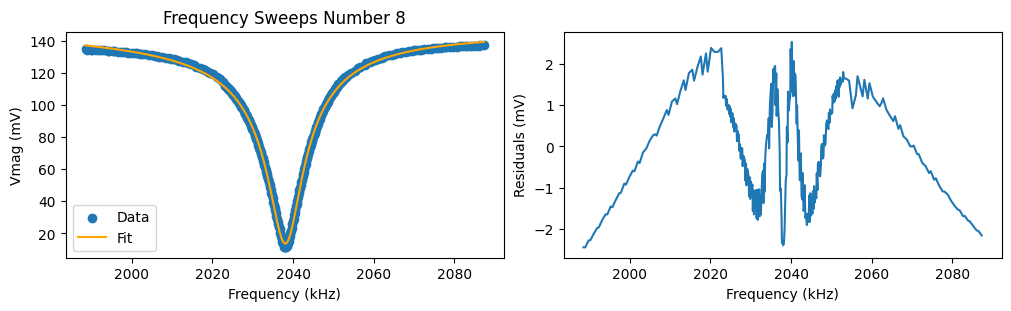

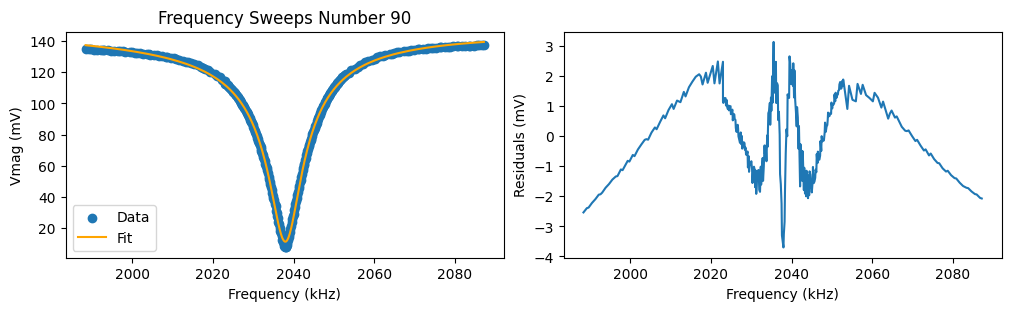

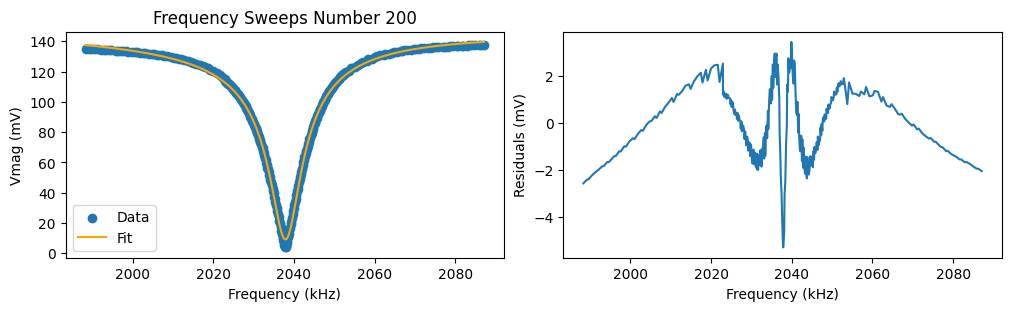

In [65]:

idx = [8,90,200]
for ind in idx:
    inds = np.logical_not(sweep_nums != ind)
    
    plot_times = times[inds]
    plot_temps = temps[inds]
    plot_vxs = vxs[inds]
    plot_vys = vys[inds]
    plot_vmags = vmags[inds]
    plot_freqs = freqs[inds]

    if True:
        l = len(freqs[inds])
        N = 4
        plot_times = plot_times[l//N:l*(N-1)//N]
        plot_temps = plot_temps[l//N:l*(N-1)//N]
        plot_vxs = plot_vxs[l//N:l*(N-1)//N]
        plot_vys = plot_vys[l//N:l*(N-1)//N]
        plot_vmags = plot_vmags[l//N:l*(N-1)//N]
        plot_freqs = plot_freqs[l//N:l*(N-1)//N]

    guesses1 = [plot_freqs[np.argmin(plot_vmags)],186,-2.35e3,5e2]
    pbounds1 = np.array([[500,1,-1e4,0],[4000,1e3,1e4,2e3]]) # [[Lower bounds],[upper bounds]]
    guesses1[0] = plot_freqs[np.argmin(plot_vmags)]
    guesses1[2] = (plot_vmags[0]+plot_vmags[-1])/2
    bestfit = optimize.curve_fit(simple_lorenzian_fit,plot_freqs,plot_vmags,guesses1, bounds=pbounds1)
    bestpars1 = bestfit[0]
    # print(bestpars1)

    guesses2 = [plot_freqs[np.argmin(plot_vmags)],186,-2.35e3,5e2,-3.3e-2,1.2]
    pbounds2 = np.array([[500,1,-1e4,0,-1,-10],[4000,1e3,1e4,2e3,1,10]]) # [[Lower bounds],[upper bounds]]
    guesses2[0] = plot_freqs[np.argmin(plot_vmags)]
    guesses2[2] = (plot_vmags[0]+plot_vmags[-1])/2
    bestfit = optimize.curve_fit(full_lorenzian_fit_with_skew,plot_freqs,plot_vmags,guesses2, bounds=pbounds2)
    bestpars2 = bestfit[0]
    # print(bestpars2)



    # Simple versus with Skew
    # fig1 = plt.figure(constrained_layout = True)
    # ax = fig1.add_subplot(2, 2, 1)
    # ax.set_xlabel('Frequency (kHz)')
    # ax.set_ylabel('Vmag (mV)')
    # ax.set_title('Frequency Sweeps Number '+str(ind))
    # ax.scatter(plot_freqs,plot_vmags,label = 'Data')
    # ax.plot(plot_freqs,simple_lorenzian_fit(plot_freqs,*bestpars1),label = 'Simple Fit',c='orange')
    # ax.legend()
    # bx = fig1.add_subplot(2, 2, 3)
    # bx.set_xlabel('Frequency (kHz)')
    # bx.set_ylabel('Vmag - fit')
    # bx.plot(plot_freqs,(plot_vmags-simple_lorenzian_fit(plot_freqs,*bestpars1))/1)

    # cx = fig1.add_subplot(2, 2, 2)
    # cx.set_xlabel('Frequency (kHz)')
    # cx.set_ylabel('Vmag (mV)')
    # cx.set_title('Frequency Sweeps Number '+str(ind))
    # cx.scatter(plot_freqs,plot_vmags,label = 'Data')
    # cx.plot(plot_freqs,full_lorenzian_fit_with_skew(plot_freqs,*bestpars2),label = 'Skew Fit',c='orange')
    # cx.legend()
    # dx = fig1.add_subplot(2, 2, 4)
    # dx.set_xlabel('Frequency (kHz)')
    # dx.set_ylabel('Vmag - fit')
    # dx.plot(plot_freqs,(plot_vmags-full_lorenzian_fit_with_skew(plot_freqs,*bestpars2))/1)

    fig2 = plt.figure(constrained_layout = True,figsize=(10,3))
    cx = fig2.add_subplot(1, 2, 1)
    cx.set_xlabel('Frequency (kHz)')
    cx.set_ylabel('Vmag (mV)')
    cx.set_title('Frequency Sweeps Number '+str(ind))
    cx.scatter(plot_freqs,plot_vmags,label = 'Data')
    cx.plot(plot_freqs,full_lorenzian_fit_with_skew(plot_freqs,*bestpars2),label = 'Fit',c='orange')
    cx.legend()
    dx = fig2.add_subplot(1, 2, 2)
    dx.set_xlabel('Frequency (kHz)')
    dx.set_ylabel('Residuals (mV)')
    dx.plot(plot_freqs,(plot_vmags-full_lorenzian_fit_with_skew(plot_freqs,*bestpars2))/1)